In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np


def poly_lr_scheduler(optimizer, init_lr, iter, lr_decay_iter=1,
                      max_iter=300, power=0.9):
    """Polynomial decay of learning rate
            :param init_lr is base learning rate
            :param iter is a current iteration
            :param lr_decay_iter how frequently decay occurs, default is 1
            :param max_iter is number of maximum iterations
            :param power is a polymomial power

    """
    # if iter % lr_decay_iter or iter > max_iter:
    # 	return optimizer

    lr = init_lr*(1 - iter/max_iter)**power
    optimizer.param_groups[0]['lr'] = lr
    return lr
    # return lr


def fast_hist(a, b, n):
    '''
    a and b are label and prediction respectively
    n is the number of classes
    '''
    k = (a >= 0) & (a < n)
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)


def per_class_iou(hist):
    epsilon = 1e-5
    return (np.diag(hist)) / (hist.sum(1) + hist.sum(0) - np.diag(hist) + epsilon)


In [ ]:
import torch
from torchvision import models


class resnet18(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.resnet18(pretrained=pretrained)
        self.conv1 = self.features.conv1
        self.bn1 = self.features.bn1
        self.relu = self.features.relu
        self.maxpool1 = self.features.maxpool
        self.layer1 = self.features.layer1
        self.layer2 = self.features.layer2
        self.layer3 = self.features.layer3
        self.layer4 = self.features.layer4

    def forward(self, input):
        x = self.conv1(input)
        x = self.relu(self.bn1(x))
        x = self.maxpool1(x)
        feature1 = self.layer1(x)  # 1 / 4
        feature2 = self.layer2(feature1)  # 1 / 8
        feature3 = self.layer3(feature2)  # 1 / 16
        feature4 = self.layer4(feature3)  # 1 / 32
        # global average pooling to build tail
        tail = torch.mean(feature4, 3, keepdim=True)
        tail = torch.mean(tail, 2, keepdim=True)
        return feature3, feature4, tail


class resnet101(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.resnet101(pretrained=pretrained)
        self.conv1 = self.features.conv1
        self.bn1 = self.features.bn1
        self.relu = self.features.relu
        self.maxpool1 = self.features.maxpool
        self.layer1 = self.features.layer1
        self.layer2 = self.features.layer2
        self.layer3 = self.features.layer3
        self.layer4 = self.features.layer4

    def forward(self, input):
        x = self.conv1(input)
        x = self.relu(self.bn1(x))
        x = self.maxpool1(x)
        feature1 = self.layer1(x)  # 1 / 4
        feature2 = self.layer2(feature1)  # 1 / 8
        feature3 = self.layer3(feature2)  # 1 / 16
        feature4 = self.layer4(feature3)  # 1 / 32
        # global average pooling to build tail
        tail = torch.mean(feature4, 3, keepdim=True)
        tail = torch.mean(tail, 2, keepdim=True)
        return feature3, feature4, tail


def build_contextpath(name):
    model = {
        'resnet18': resnet18(pretrained=True),
        'resnet101': resnet101(pretrained=True)
    }
    return model[name]

In [ ]:
import torch
from torch import nn
import warnings
warnings.filterwarnings(action='ignore')


class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.conv1(input)
        return self.relu(self.bn(x))


class Spatial_path(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.convblock1 = ConvBlock(in_channels=3, out_channels=64)
        self.convblock2 = ConvBlock(in_channels=64, out_channels=128)
        self.convblock3 = ConvBlock(in_channels=128, out_channels=256)

    def forward(self, input):
        x = self.convblock1(input)
        x = self.convblock2(x)
        x = self.convblock3(x)
        return x


class AttentionRefinementModule(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.sigmoid = nn.Sigmoid()
        self.in_channels = in_channels
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    def forward(self, input):
        # global average pooling
        x = self.avgpool(input)
        assert self.in_channels == x.size(1), 'in_channels and out_channels should all be {}'.format(x.size(1))
        x = self.conv(x)
        x = self.sigmoid(self.bn(x))
        # x = self.sigmoid(x)
        # channels of input and x should be same
        x = torch.mul(input, x)
        return x


class FeatureFusionModule(torch.nn.Module):
    def __init__(self, num_classes, in_channels):
        super().__init__()
        # self.in_channels = input_1.channels + input_2.channels
        # resnet101 3328 = 256(from spatial path) + 1024(from context path) + 2048(from context path)
        # resnet18  1024 = 256(from spatial path) + 256(from context path) + 512(from context path)
        self.in_channels = in_channels

        self.convblock = ConvBlock(in_channels=self.in_channels, out_channels=num_classes, stride=1)
        self.conv1 = nn.Conv2d(num_classes, num_classes, kernel_size=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(num_classes, num_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    def forward(self, input_1, input_2):
        x = torch.cat((input_1, input_2), dim=1)
        assert self.in_channels == x.size(1), 'in_channels of ConvBlock should be {}'.format(x.size(1))
        feature = self.convblock(x)
        x = self.avgpool(feature)

        x = self.relu(self.conv1(x))
        x = self.sigmoid(self.conv2(x))
        x = torch.mul(feature, x)
        x = torch.add(x, feature)
        return x


class BiSeNet(torch.nn.Module):
    def __init__(self, num_classes, context_path):
        super().__init__()
        # build spatial path
        self.saptial_path = Spatial_path()

        # build context path
        self.context_path = build_contextpath(name=context_path)

        # build attention refinement module  for resnet 101
        if context_path == 'resnet101':
            self.attention_refinement_module1 = AttentionRefinementModule(1024, 1024)
            self.attention_refinement_module2 = AttentionRefinementModule(2048, 2048)
            # supervision block
            self.supervision1 = nn.Conv2d(in_channels=1024, out_channels=num_classes, kernel_size=1)
            self.supervision2 = nn.Conv2d(in_channels=2048, out_channels=num_classes, kernel_size=1)
            # build feature fusion module
            self.feature_fusion_module = FeatureFusionModule(num_classes, 3328)

        elif context_path == 'resnet18':
            # build attention refinement module  for resnet 18
            self.attention_refinement_module1 = AttentionRefinementModule(256, 256)
            self.attention_refinement_module2 = AttentionRefinementModule(512, 512)
            # supervision block
            self.supervision1 = nn.Conv2d(in_channels=256, out_channels=num_classes, kernel_size=1)
            self.supervision2 = nn.Conv2d(in_channels=512, out_channels=num_classes, kernel_size=1)
            # build feature fusion module
            self.feature_fusion_module = FeatureFusionModule(num_classes, 1024)
        else:
            print('Error: unspport context_path network \n')

        # build final convolution
        self.conv = nn.Conv2d(in_channels=num_classes, out_channels=num_classes, kernel_size=1)

        self.init_weight()

        self.mul_lr = []
        self.mul_lr.append(self.saptial_path)
        self.mul_lr.append(self.attention_refinement_module1)
        self.mul_lr.append(self.attention_refinement_module2)
        self.mul_lr.append(self.supervision1)
        self.mul_lr.append(self.supervision2)
        self.mul_lr.append(self.feature_fusion_module)
        self.mul_lr.append(self.conv)

    def init_weight(self):
        for name, m in self.named_modules():
            if 'context_path' not in name:
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                elif isinstance(m, nn.BatchNorm2d):
                    m.eps = 1e-5
                    m.momentum = 0.1
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    def forward(self, input):
        # output of spatial path
        sx = self.saptial_path(input)

        # output of context path
        cx1, cx2, tail = self.context_path(input)
        cx1 = self.attention_refinement_module1(cx1)
        cx2 = self.attention_refinement_module2(cx2)
        cx2 = torch.mul(cx2, tail)
        # upsampling
        cx1 = torch.nn.functional.interpolate(cx1, size=sx.size()[-2:], mode='bilinear')
        cx2 = torch.nn.functional.interpolate(cx2, size=sx.size()[-2:], mode='bilinear')
        cx = torch.cat((cx1, cx2), dim=1)

        if self.training == True:
            cx1_sup = self.supervision1(cx1)
            cx2_sup = self.supervision2(cx2)
            cx1_sup = torch.nn.functional.interpolate(cx1_sup, size=input.size()[-2:], mode='bilinear')
            cx2_sup = torch.nn.functional.interpolate(cx2_sup, size=input.size()[-2:], mode='bilinear')

        # output of feature fusion module
        result = self.feature_fusion_module(sx, cx)

        # upsampling
        result = torch.nn.functional.interpolate(result, scale_factor=8, mode='bilinear')
        result = self.conv(result)

        if self.training == True:
            return result, cx1_sup, cx2_sup

        return result

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple


class CityScapes(Dataset):
    def __init__(self, root_dir, split='val', transform=None, target_transform=None):
        super(CityScapes, self).__init__()
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.target_transform = target_transform

        self.images_dir = os.path.join(root_dir, 'leftImg8bit', split)
        self.labels_dir = os.path.join(root_dir, 'gtFine', split)

        self.images = []
        self.labels = []

        for city in os.listdir(self.images_dir):
            img_dir = os.path.join(self.images_dir, city)
            lbl_dir = os.path.join(self.labels_dir, city)

            for file_name in os.listdir(img_dir):
                if file_name.endswith('_leftImg8bit.png'):
                    img_path = os.path.join(img_dir, file_name)
                    lbl_path = os.path.join(lbl_dir, file_name.replace('_leftImg8bit.png', '_gtFine_labelTrainIds.png'))

                    if not os.path.exists(img_path):
                        print(f"Image file does not exist: {img_path}")
                    if not os.path.exists(lbl_path):
                        print(f"Label file does not exist: {lbl_path}")

                    self.images.append(img_path)
                    self.labels.append(lbl_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        lbl_path = self.labels[idx]

        image = Image.open(img_path).convert('RGB')
        label = Image.open(lbl_path)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

    def get_class_names(self):
        return ['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign',
                'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train',
                'motorcycle', 'bicycle']


In [ ]:
import os
from PIL import Image, UnidentifiedImageError
import torch
from torch.utils.data import Dataset
import numpy as np
from torchvision import transforms

class GTA5(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None):
        super(GTA5, self).__init__()
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform

        self.images_dir = os.path.join(self.root_dir, 'images')
        self.labels_dir = os.path.join(self.root_dir, 'labels')

        self.images = []
        self.labels = []

        for image in os.listdir(self.images_dir):
            image_path = os.path.join(self.images_dir, image)
            label_path = os.path.join(self.labels_dir, image)
            if os.path.exists(label_path):
                self.images.append(image_path)
                self.labels.append(label_path)

        # Map from color to corresponding class of Cityscapes
        self.color_to_id = {
            (128, 64, 128): 0,   # road
            (244, 35, 232): 1,   # sidewalk
            (70, 70, 70): 2,     # building
            (102, 102, 156): 3,  # wall
            (190, 153, 153): 4,  # fence
            (153, 153, 153): 5,  # pole
            (250, 170, 30): 6,   # light
            (220, 220, 0): 7,    # sign
            (107, 142, 35): 8,   # vegetation
            (152, 251, 152): 9,  # terrain
            (70, 130, 180): 10,  # sky
            (220, 20, 60): 11,   # person
            (255, 0, 0): 12,     # rider
            (0, 0, 142): 13,     # car
            (0, 0, 70): 14,      # truck
            (0, 60, 100): 15,    # bus
            (0, 80, 100): 16,    # train
            (0, 0, 230): 17,     # motorcycle
            (119, 11, 32): 18    # bicycle
        }

    def __getitem__(self, idx):
        try:
            image = Image.open(self.images[idx]).convert('RGB')
            label = Image.open(self.labels[idx]).convert('RGB')
        except (UnidentifiedImageError, FileNotFoundError) as e:
            print(f"Error loading image {self.images[idx]} or label {self.labels[idx]}, skipping...")
            return self.__getitem__((idx + 1) % len(self.images))

        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            label = self.target_transform(label)
            label = self.map_color_to_class(label)

        return image, label

    def __len__(self):
        return len(self.images)

    def map_color_to_class(self, label):
        # Convert the RGB image to a single integer value
        label_int = label[:, :, 0] * 256 * 256 + label[:, :, 1] * 256 + label[:, :, 2]

        # Create a tensor of the same shape as the input image, filled with 255 (the class for 'unlabeled')
        class_id_image = torch.full_like(label_int, 255)

        # Replace each unique color value with the corresponding class
        for color, class_id in self.color_to_id.items():
            color_int = color[0] * 256 * 256 + color[1] * 256 + color[2]
            class_id_image = torch.where(label_int == color_int, class_id, class_id_image)

        return class_id_image


In [ ]:
import os
import warnings
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from typing import Tuple

# Ignore warnings
warnings.filterwarnings(action='ignore')

# Define transformations
resize_transform = transforms.Resize((512, 1024))
augmentations_1 = transforms.Compose([
    resize_transform,
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
gta5_target_transform = transforms.Compose([
    transforms.Resize((512, 1024), interpolation=Image.NEAREST),
    transforms.Lambda(lambda lbl: torch.tensor(np.array(lbl), dtype=torch.long)),
])
cityscapes_transform = transforms.Compose([
    transforms.Resize((512, 1024)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
cityscapes_target_transform = transforms.Compose([
    transforms.Resize((512, 1024), interpolation=Image.NEAREST),
    transforms.Lambda(lambda lbl: torch.tensor(np.array(lbl), dtype=torch.long)),
])



In [ ]:
import os
import warnings
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image, UnidentifiedImageError
from typing import Tuple
import matplotlib.pyplot as plt

#Create Dataloaders for Cityscapes and GTA5
gta5_root ='/content/drive/MyDrive/MLDLMLDL/GTA5'
cityscapes_root = '/content/drive/MyDrive/MLDLMLDL/Cityscapes/Cityscapes/Cityspaces'

gta5_dataset = GTA5(gta5_root,transform=augmentations_1, target_transform=gta5_target_transform)
cityscapes_dataset = CityScapes(root_dir=cityscapes_root, split='val', transform=cityscapes_transform, target_transform=cityscapes_target_transform)

gta5_loader = DataLoader(gta5_dataset, batch_size=8, shuffle=True,num_workers=12)
cityscapes_loader = DataLoader(cityscapes_dataset, batch_size=8, shuffle=True,num_workers=12)

num_classes = 19

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize BiSeNet model
bisenet_model = BiSeNet(num_classes=19, context_path='resnet18').to(device)

# Initialize optimizer and loss function
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.SGD(bisenet_model.parameters(), lr=0.02, momentum=0.9, weight_decay=1e-4)

num_epochs = 50
max_iter = num_epochs * len(gta5_loader)
init_lr = 0.02

class_names = cityscapes_dataset.get_class_names()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 200MB/s]
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:05<00:00, 34.4MB/s]


In [ ]:
print(len(cityscapes_dataset))
print(len(gta5_dataset))

500
2500


In [ ]:
def generate_mixed_samples(source_images, source_labels, target_images, alpha=0.3):
    mixed_images = []
    mixed_labels = []
    for src_img, src_lbl, tgt_img in zip(source_images, source_labels, target_images):
        mask = (torch.rand(src_img.size()) > alpha).to(device)
        mixed_img = torch.where(mask, src_img, tgt_img)
        mixed_lbl = src_lbl
        mixed_images.append(mixed_img)
        mixed_labels.append(mixed_lbl)
    return torch.stack(mixed_images), torch.stack(mixed_labels)


In [ ]:
def generate_pseudo_labels(model, images):
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, pseudo_labels = torch.max(outputs, 1)
    model.train()
    return pseudo_labels


Epoch [1/50], Step [1/313], Loss: 0.3804
Epoch [1/50], Step [11/313], Loss: 0.3160
Epoch [1/50], Step [21/313], Loss: 0.3392
Epoch [1/50], Step [31/313], Loss: 0.2999
Epoch [1/50], Step [41/313], Loss: 0.3987
Epoch [1/50], Step [51/313], Loss: 0.3873
Epoch [1/50], Step [61/313], Loss: 0.3671
Epoch [1/50], Step [71/313], Loss: 0.4404
Epoch [1/50], Step [81/313], Loss: 0.3644
Epoch [1/50], Step [91/313], Loss: 0.3177
Epoch [1/50], Step [101/313], Loss: 0.3407
Epoch [1/50], Step [111/313], Loss: 0.3089
Epoch [1/50], Step [121/313], Loss: 0.4083
Epoch [1/50], Step [131/313], Loss: 0.3454
Epoch [1/50], Step [141/313], Loss: 0.3732
Epoch [1/50], Step [151/313], Loss: 0.3108
Epoch [1/50], Step [161/313], Loss: 0.3070
Error loading image /content/drive/MyDrive/MLDLMLDL/GTA5/images/00417.png or label /content/drive/MyDrive/MLDLMLDL/GTA5/labels/00417.png, skipping...
Epoch [1/50], Step [171/313], Loss: 0.3835
Epoch [1/50], Step [181/313], Loss: 0.3156
Epoch [1/50], Step [191/313], Loss: 0.3261
E

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7befdba4bbe0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7befdba4bbe0>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7befdba4bbe0>Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in: 
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7befdba4bbe0><function _MultiProcessingDataLoaderIter.__del__ at 0x7befdba4bbe0><function _MultiProcessingDataLoaderIter.__del__ at 0x7befdba4bbe0>
    self._shutdown_workers()Traceback (most recent call last):

self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in

Epoch [24/50], Step [1/313], Loss: 0.1493
Error loading image /content/drive/MyDrive/MLDLMLDL/GTA5/images/00417.png or label /content/drive/MyDrive/MLDLMLDL/GTA5/labels/00417.png, skipping...
Epoch [24/50], Step [11/313], Loss: 0.1548
Epoch [24/50], Step [21/313], Loss: 0.1641
Epoch [24/50], Step [31/313], Loss: 0.2057
Epoch [24/50], Step [41/313], Loss: 0.1739
Epoch [24/50], Step [51/313], Loss: 0.1858
Epoch [24/50], Step [61/313], Loss: 0.1689
Epoch [24/50], Step [71/313], Loss: 0.1736
Epoch [24/50], Step [81/313], Loss: 0.2287
Epoch [24/50], Step [91/313], Loss: 0.1673
Epoch [24/50], Step [101/313], Loss: 0.1795
Epoch [24/50], Step [111/313], Loss: 0.1744
Epoch [24/50], Step [121/313], Loss: 0.1870
Epoch [24/50], Step [131/313], Loss: 0.2044
Epoch [24/50], Step [141/313], Loss: 0.1783
Epoch [24/50], Step [151/313], Loss: 0.1582
Epoch [24/50], Step [161/313], Loss: 0.1781
Epoch [24/50], Step [171/313], Loss: 0.2255
Epoch [24/50], Step [181/313], Loss: 0.1677
Epoch [24/50], Step [191/

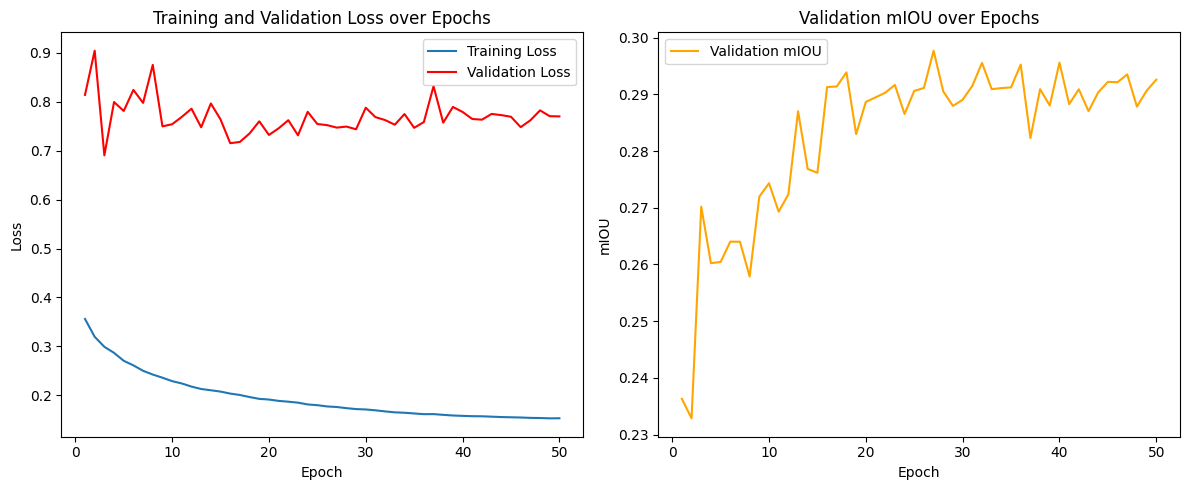

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def perturb_images(images, noise_std=0.1):
    noise = torch.randn_like(images) * noise_std
    perturbed_images = images + noise
    return perturbed_images

best_miou = 0
best_epoch = 0
train_losses = []
val_losses = []
val_mious = []

alpha = 0.3
consistency_weight = 0.1

for epoch in range(num_epochs):
    bisenet_model.train()
    running_loss = 0.0

    cityscapes_loader_iter = iter(cityscapes_loader)

    for i, (source_images, source_labels) in enumerate(gta5_loader):
        try:
            target_images, _ = next(cityscapes_loader_iter)
        except StopIteration:
            cityscapes_loader_iter = iter(cityscapes_loader)
            target_images, _ = next(cityscapes_loader_iter)

        source_images, source_labels = source_images.to(device), source_labels.to(device)
        target_images = target_images.to(device)

        # Ensure batch sizes are the same
        batch_size = min(source_images.size(0), target_images.size(0))
        source_images = source_images[:batch_size]
        source_labels = source_labels[:batch_size]
        target_images = target_images[:batch_size]

        # Generate pseudo-labels for target images
        pseudo_labels = generate_pseudo_labels(bisenet_model, target_images)
        pseudo_probs = F.softmax(bisenet_model(target_images)[0], dim=1).max(dim=1)[0]


        mixed_images, mixed_labels = generate_mixed_samples(source_images, source_labels, target_images, alpha=alpha)

        optimizer.zero_grad()

        outputs, aux1, aux2 = bisenet_model(mixed_images)
        loss_source = criterion(outputs, mixed_labels)

        # Consistency loss
        perturbed_images = perturb_images(mixed_images)  # Apply perturbation
        perturbed_outputs, _, _ = bisenet_model(perturbed_images)
        consistency_loss = F.mse_loss(outputs, perturbed_outputs)

        loss = loss_source + consistency_weight * consistency_loss

        loss.backward()
        optimizer.step()

        iter_num = epoch * len(gta5_loader) + i
        poly_lr_scheduler(optimizer, init_lr, iter_num, max_iter=max_iter)

        running_loss += loss.item()

        if i % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(gta5_loader)}], Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(gta5_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {epoch_loss:.4f}")

    # Validation on Cityscapes dataset
    bisenet_model.eval()
    val_running_loss = 0.0
    hist = np.zeros((19, 19))
    with torch.no_grad():
        for i, (images, labels) in enumerate(cityscapes_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = bisenet_model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()
            labels_np = labels.cpu().numpy()

            hist += fast_hist(labels_np.flatten(), preds.flatten(), 19)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()

    epoch_val_loss = val_running_loss / len(cityscapes_loader)
    val_losses.append(epoch_val_loss)
    ious = per_class_iou(hist)
    for idx, iou in enumerate(ious):
        print(f"Class {class_names[idx]}: mIOU = {iou:.4f}")

    mean_iou = np.mean(ious)
    val_mious.append(mean_iou)
    print(f"Mean IOU: {mean_iou:.4f}")

    # Save best model
    if mean_iou > best_miou:
        best_miou = mean_iou
        best_epoch = epoch + 1
        torch.save(bisenet_model.state_dict(), '/content/drive/MyDrive/MLDLMLDL/best_DACS2_model.pth')
        print(f"Best model saved with mIOU: {best_miou:.4f} at epoch {best_epoch}")

# Plot training loss, validation loss, and validation mIOU
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_mious, label='Validation mIOU', color='orange')
plt.xlabel('Epoch')
plt.ylabel('mIOU')
plt.title('Validation mIOU over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
